In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [254]:
df = pd.read_csv('train.csv')
df['Transported'] = df['Transported'].astype(int)

In [255]:
def fill_roomnumber(df, col):
    df['Roomnumber'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
    r_to_c = (df[['Roomnumber', col]]
        .dropna()
        .groupby('Roomnumber')[col]
        .apply(lambda x: x.mode()[0]))
    
    df[col] = df.apply(lambda row: r_to_c[row['Roomnumber']] 
                       if pd.isna(row[col]) and row['Roomnumber'] in r_to_c.index 
                       else row[col], axis = 1)
    df[col] = df.groupby('Roomnumber')[col].ffill().bfill()

In [256]:
def fillna(df):
    fill_roomnumber(df, 'Cabin')
    fill_roomnumber(df, 'Destination')
    fill_roomnumber(df, 'HomePlanet')
    
    expense_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpent'] = df[expense_columns].sum(axis=1)
    
    for expense in expense_columns:
        df[expense] = df.apply(lambda row: 0 if row['CryoSleep'] else row[expense], axis=1)

    df['CryoSleep'] = df.apply(lambda row: False if pd.isna(row['CryoSleep']) and row['TotalSpent'] > 0 else row['CryoSleep'], axis=1)
    df['CryoSleep'] = df.apply(lambda row: True if pd.isna(row['CryoSleep']) and row['TotalSpent'] == 0 else row['CryoSleep'], axis=1)
    
    df['VIP'] = df['VIP'].fillna(df['VIP'].mode()[0])

    remaining_nan = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in remaining_nan:
        df[col] = df[col].fillna(df[col].mean())

In [257]:
def feature_eng(df):
    #df['CryoSleep'] = df['CryoSleep'].astype(int)
    #df['VIP'] = df['VIP'].astype(int)
    df['CabinLetter'] = df['Cabin'].apply(lambda x: x.split('/')[0])
    df['CabinNumber'] = df['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
    df['CabinType'] = df['Cabin'].apply(lambda x: x.split('/')[2])
    df.drop(columns = ['PassengerId', 'Name', 'Cabin'], inplace=True)

In [258]:
fillna(df)
feature_eng(df)

In [259]:
# Q1 = df.quantile(0.25, numeric_only=True)
# Q3 = df.quantile(0.75, numeric_only=True)
# IQS = Q3 - Q1

# outliers = ((df[IQS.index] < Q1 - 1.5*IQS) | (df[IQS.index] > Q3 + 1.5*IQS)).any(axis=1)
# df = df[~outliers]

In [260]:
df_dummy = pd.get_dummies(df)

<Axes: >

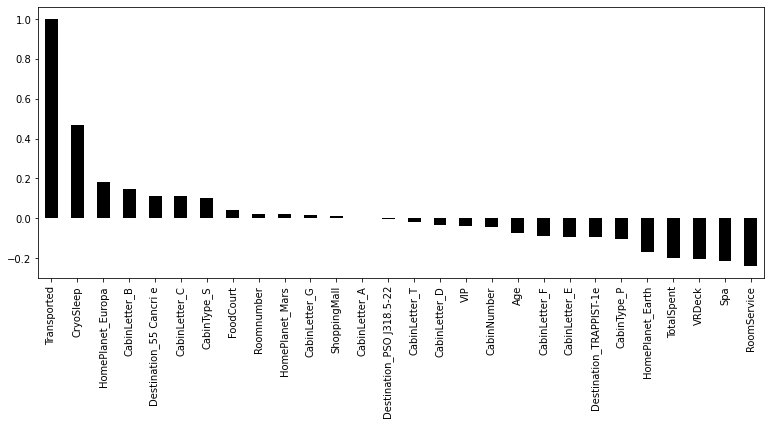

In [261]:
df_dummy.corr()['Transported'].sort_values(ascending=False).plot.bar(cmap='copper', figsize=(13,5))

In [262]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = df_dummy.drop(columns = 'Transported')
y = df_dummy['Transported']

features = X.columns.values
Scaler = StandardScaler()
X = Scaler.fit_transform(X)
X = pd.DataFrame(X, columns = features)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [263]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

print("Training error: ", model.score(X_train, y_train))
print("Test error:", model.score(X_valid, y_valid))

Training error:  0.9473684210526315
Test error: 0.8004600345025877


<Axes: >

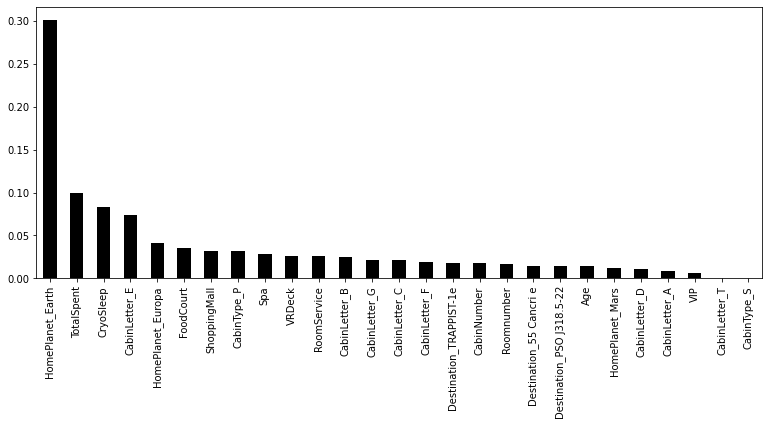

In [264]:
pd.Series(model.feature_importances_, index=features).sort_values(ascending=False).plot.bar(cmap='copper', figsize=(13,5))

In [269]:
test_df = pd.read_csv('test.csv')

In [270]:
fillna(test_df)

In [271]:
ids = test_df['PassengerId']
feature_eng(test_df)

In [272]:
X_test = pd.get_dummies(test_df)
features = X_test.columns.values

In [273]:
X_test = Scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = features)

In [274]:
y_test = model.predict(X_test)
y_test = y_test.astype(bool)

In [275]:
output = pd.DataFrame({'PassengerId': ids, 'Transported': y_test})

In [276]:
output.to_csv('submission4.csv', index=False)